In [1]:
# package loading
import sqlite3
import pandas as pd
from datetime import datetime
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.python.keras.engine import input_layer
import os
from keras.models import load_model

In [2]:
# connect DB
conn = sqlite3.connect('stock_price.db')
cur = conn.cursor()

In [3]:
# load data
lmt = 'LMT'
lmt_df = pd.read_sql('select * from LMT', con=conn)

In [22]:
lmt_df

,open,high,low,close,adj_close,volume
date,,,,,,
2022-02-01,390.22,390.51,386.21,387.01,387.01,1951100
2022-01-31,390.50,390.99,384.68,389.13,389.13,2363400
2022-01-28,389.10,393.33,384.78,393.15,393.15,2145100
2022-01-27,389.39,395.60,384.74,389.08,389.08,2566200
2022-01-26,388.00,393.63,383.70,391.24,391.24,3640500
...,...,...,...,...,...,...
2017-02-08,256.93,257.81,256.40,256.74,225.10,973400
2017-02-07,256.00,257.30,255.58,256.37,224.78,977800
2017-02-06,254.43,257.07,254.11,255.31,223.85,980800


In [5]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 0 ~ 1 사이의 값으로 변환(계산시간 단축)"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [6]:
lmt_df = lmt_df.set_index('date')

In [7]:
lmt_df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2022-02-01,390.22,390.51,386.21,387.01,387.01,1951100
2022-01-31,390.50,390.99,384.68,389.13,389.13,2363400
2022-01-28,389.10,393.33,384.78,393.15,393.15,2145100
2022-01-27,389.39,395.60,384.74,389.08,389.08,2566200
2022-01-26,388.00,393.63,383.70,391.24,391.24,3640500


In [8]:
# set data
lmt_dfx = lmt_df[['adj_close', 'open', 'high', 'low', 'volume']]
lmt_dfx = MinMaxScaler(lmt_dfx)
lmt_dfy = lmt_dfx[['adj_close']]
x = lmt_dfx.values.tolist()
y = lmt_dfy.values.tolist()

In [9]:
# data handling
data_x = []
data_y = []
size = 10 # 10일간의 종가-고가-저가-거래량-종가 데이터를 의미함
for i in range(len(y) - size):
    _x = x[i : i + size]
    _y = y[i + size]
    data_x.append(_x)
    data_y.append(_y)

In [10]:
# data separate(train 70%, test 30%)
## train data
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])
## test data
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

In [11]:
# modeling
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(size, 5)))
model.add(Dropout(0.1))
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            640       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# train model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=60, batch_size=30)

Epoch 1/60
30/30 [==============================] - 3s 10ms/step - loss: 0.2098
Epoch 2/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 3/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0179
Epoch 4/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0147
Epoch 5/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0129
Epoch 6/60
30/30 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 7/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 8/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 9/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0117
Epoch 10/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 11/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 12/60
30/30 [==============================] - 0s 10ms/step - loss: 0.0120
Epoch 13/60
30/30 [==================

In [13]:
# model save
predict_price = model.predict(test_x)

model.save('model.h5') # model save

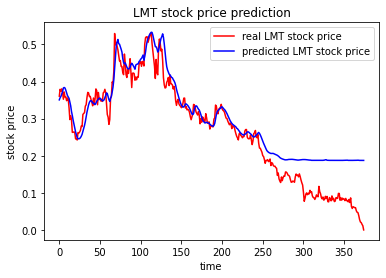

In [15]:
plt.figure()
plt.plot(test_y, color='red', label='real LMT stock price')
plt.plot(predict_price, color='blue', label='predicted LMT stock price')
plt.title('LMT stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [26]:
print("LMT tomorrow's price: ", lmt_df.adj_close[0]*predict_price[0]/lmt_dfy.adj_close[0])

LMT tomorrow's price:  [159.54787]
